# 대회 개요


## 주제
- 공기압축기 이상 판단(제4회 2023 연구개발특구 AI SPARK 챌린지)
- 산업기기 피로도를 예측하는 문제

## 모델 조건
- 모델링은 비지도학습 방식으로 진행
- 입력된 데이터를 정상(0), 이상(1)로 구분하는 이진 분류 모델
- 시간 단위로 생성되는 입력 데이터에 대하여 판정을 수행할 수 있는 모델
- 신규 데이터로 학습/개선이 가능한 모델
- 외부 공공 데이터 사용 가능

## 기타 중요 내용
- 반드시 리더보드상의 순위 기록에 해당되는 버전의 코드/모델 가중치를 제출
- 소스코드 내의 모든 무작위성은 seed 설정을 통해 통제

# 데이터 불러오기

* train_data
    * 학습용 데이터 
    * 모두 정상 case로 이루어짐
    * (2463 * 8)
* test_data
    * 평가용 데이터
    * 정상 case와 이상 case가 함께 포함됨
    * (7389 * 8)

* 구성
    - air_inflow: 공기 흡입 유량 (^3/min)
    - air_end_temp: 공기 말단 온도 (°C)
    - out_pressure: 토출 압력 (Mpa)
    - motor_current: 모터 전류 (A)
    - motor_rpm: 모터 회전수 (rpm)
    - motor_temp: 모터 온도 (°C)
    - motor_vibe: 모터 진동 (mm/s)
    - type: 설비 번호
        - 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
        - 설비 번호 1: 20HP
        - 설비 번호 2: 10HP
        - 설비 번호 3: 50HP


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train_data = pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/train_data.csv")
test_data= pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/test_data.csv")

# 데이터 전처리

### type -> hp(Horse Power)
    * type: 설비 번호
        - 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
        - 설비 번호 1: 20HP
        - 설비 번호 2: 10HP
        - 설비 번호 3: 50HP

In [ ]:
mapping_dict = {
    2: 10,
    1: 20,
    0: 30,
    4: 30, 
    5: 30,
    6: 30,
    7: 30,
    3: 50,
}

train_data['hp'] = train_data['type'].map(mapping_dict)
test_data['hp'] = test_data['type'].map(mapping_dict)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   type           2463 non-null   int64  
 8   hp             2463 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 173.3 KB


### motor_vibe 이상치 삭제 및 중복 데이터 제거

In [ ]:
# 중복데이터 144개
train_data = train_data.drop_duplicates()

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2462
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2319 non-null   float64
 1   air_end_temp   2319 non-null   float64
 2   out_pressure   2319 non-null   float64
 3   motor_current  2319 non-null   float64
 4   motor_rpm      2319 non-null   float64
 5   motor_temp     2319 non-null   float64
 6   motor_vibe     2319 non-null   float64
 7   type           2319 non-null   int64  
 8   hp             2319 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 181.2 KB


In [ ]:
# 20HP 에서 motor_vibe값이 이상치로 판단되는 행 제거: 16개
train_data = train_data.loc[train_data['motor_vibe'] < 20.0, :]

In [ ]:
train_data.info()

### 새로운 Feature 추가하기

In [ ]:
# 모터 전류 당 공기 유량은 압축기의 효율성
train_data['air_inflow_per_motor_current'] = train_data['air_inflow'] / train_data['motor_current']	
test_data['air_inflow_per_motor_current'] = test_data['air_inflow'] / test_data['motor_current']

# 압축기와 모터의 상태를 모두 고려한 압축기 효율1
train_data['Compressor_Efficiency1'] = train_data['out_pressure'] * train_data['air_inflow'] / train_data['motor_current'] / 3.5168 / train_data['hp']
test_data['Compressor_Efficiency1'] = test_data['out_pressure'] * test_data['air_inflow'] / test_data['motor_current'] / 3.5168 / test_data['hp']

# 압축기와 모터의 상태를 모두 고려한 압축기 효율2
train_data['Motor_Efficiency'] = (train_data['motor_current'] * train_data['motor_rpm'] * train_data['hp']) / (746 * 1000)
test_data['Motor_Efficiency'] = (test_data['motor_current'] * test_data['motor_rpm'] * test_data['hp']) / (746 * 1000)

# 압축기의 효율2
train_data['Compressor_Efficiency2'] = (train_data['out_pressure'] * train_data['air_inflow'] * (train_data['air_end_temp'] - 25)) / (train_data['motor_current'] * train_data['motor_vibe'] * train_data['hp'] * 3.6)
test_data['Compressor_Efficiency2'] = (test_data['out_pressure'] * test_data['air_inflow'] * (test_data['air_end_temp'] - 25)) / (test_data['motor_current'] * test_data['motor_vibe'] * test_data['hp'] * 3.6)

# 압축기의 배출량
train_data['Discharge_Volume'] = (train_data['air_inflow'] / 60) * ((train_data['air_end_temp'] + 273) / 273) * (train_data['out_pressure'] / 1.01325)
test_data['Discharge_Volume'] = (test_data['air_inflow'] / 60) * ((test_data['air_end_temp'] + 273) / 273) * (test_data['out_pressure'] / 1.01325)

# 공기의 밀도
train_data['air_density'] = train_data['out_pressure'] / (287 * (train_data['air_end_temp'] + 273))
test_data['air_density'] = test_data['out_pressure'] / (287 * (test_data['air_end_temp'] + 273))

# 데이터 분석

## Pandas-profiling

In [ ]:
# !pip install pandas-profiling[notebook]

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
# pandas-profiling 보고서 생성
train_data_profile = ProfileReport(train_data)
train_data_profile.to_file(f"train_data_report(new).html")

test_data_profile = ProfileReport(test_data)
test_data_profile.to_file(f"test_data_report(new).html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## ydata-profiling(pandas-profiling과 거의 동일함)

In [ ]:
# !pip install ydata-profiling

In [ ]:
# from ydata_profiling import ProfileReport

In [ ]:
# train_profile = ProfileReport(train_data, title="Profiling Report")
# train_profile.to_file("train_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# test_profile = ProfileReport(test_data, title="Profiling Report")
# test_profile.to_file("test_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Sweetviz

In [ ]:
!pip install sweetviz

In [ ]:
import sweetviz as sv

In [ ]:
train_data_report = sv.analyze(train_data)
train_data_report.show_html("sweetviz_train_data.html")

test_data_report = sv.analyze(test_data)
test_data_report.show_html("sweetviz_test_data.html")

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_train_data.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_test_data.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## AutoViz

In [ ]:
!pip install autoviz --upgrade

In [ ]:
from autoviz.AutoViz_Class import AutoViz_Class

# AutoViz 인스턴스 생성
AV = AutoViz_Class()

In [ ]:
train_url = "https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/train_data.csv"
dft = AV.AutoViz(train_url, chart_format="html", verbose = 0)

In [ ]:
test_url = "https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/test_data.csv"
dft = AV.AutoViz(test_url, chart_format="html")

## D-Tale

In [ ]:
!pip install dtale

In [ ]:
import dtale

In [ ]:
import dtale.app as dtale_app
# https://github.com/man-group/dtale#google-colab
dtale_app.USE_COLAB = True

In [ ]:
dtale.show(train_data)

https://rylqcpjcsnc-496ff2e9c6d22116-40000-colab.googleusercontent.com/dtale/main/3

In [ ]:
dtale.show(test_data)

https://rylqcpjcsnc-496ff2e9c6d22116-40000-colab.googleusercontent.com/dtale/main/4

# 모델링

### AutoEncoder_default

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping

model_name = 'ae_ft14_standard_no_outlier_dupl'

# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 64
hidden_dim = 32

encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(hidden_dim, activation='relu')
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(hidden_dim,)),
    tf.keras.layers.Dense(input_dim, activation='linear')
])

ae_default = tf.keras.Sequential([encoder, decoder])

# Compile and train the autoencoder with early stopping
ae_default.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
history = ae_default.fit(train_data_scaled, train_data_scaled, epochs=10000, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)
ae_default.save(f"{model_name}.h5")

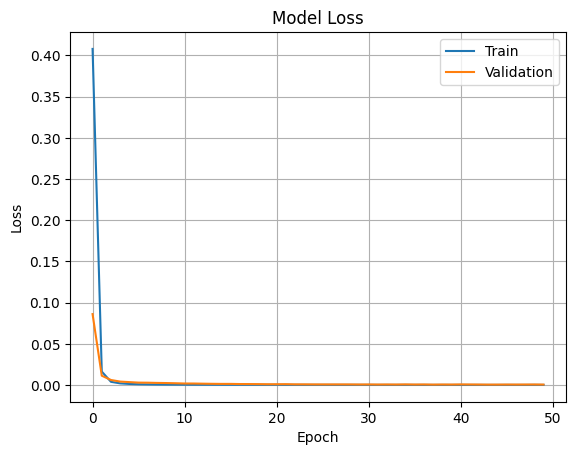

In [ ]:
# 모델 학습 과정 시각화
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 학습된 모델 로드
model = tf.keras.models.load_model(f"{model_name}.h5")

# Calculate the reconstruction error for test_data
test_data_reconstructed = model.predict(test_data_scaled)
reconstruction_error = np.mean(np.square(test_data_scaled - test_data_reconstructed), axis=1)

231/231 [==============================] - 0s 1ms/step


In [ ]:
# Set a threshold for considering a test point as an anomaly
threshold = np.percentile(reconstruction_error, 95.34)
threshold1 = np.percentile(reconstruction_error, 95.36)

# Predict anomalies in test_data
prediction = (reconstruction_error > threshold).astype(int)
prediction1 = (reconstruction_error > threshold1).astype(int)

from collections import Counter

count = Counter(prediction)
num_0 = count[0]
num_1 = count[1]

print("Number of 0s: ", num_0)
print("Number of 1s: ", num_1)

Number of 0s:  7044
Number of 1s:  345


### AutoEncoder_noValidation

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping

model_name = 'ae_ft14_standard_no_outlier_dupl_val'

# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 64
hidden_dim = 32

encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(hidden_dim, activation='relu')
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(hidden_dim,)),
    tf.keras.layers.Dense(input_dim, activation='linear')
])

ae_default = tf.keras.Sequential([encoder, decoder])

# Compile and train the autoencoder with early stopping
ae_default.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
history = ae_default.fit(train_data_scaled, train_data_scaled, epochs=50, batch_size=32, verbose=1)
ae_default.save(f"{model_name}.h5")

Epoch 1/50
72/72 [==============================] - 1s 3ms/step - loss: 0.3771
Epoch 2/50
72/72 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 3/50
72/72 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4/50
72/72 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 5/50
72/72 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 6/50
72/72 [==============================] - 0s 3ms/step - loss: 7.9442e-04
Epoch 7/50
72/72 [==============================] - 0s 3ms/step - loss: 6.2989e-04
Epoch 8/50
72/72 [==============================] - 0s 3ms/step - loss: 5.2872e-04
Epoch 9/50
72/72 [==============================] - 0s 3ms/step - loss: 4.6183e-04
Epoch 10/50
72/72 [==============================] - 0s 3ms/step - loss: 4.1348e-04
Epoch 11/50
72/72 [==============================] - 0s 3ms/step - loss: 3.6537e-04
Epoch 12/50
72/72 [==============================] - 0s 3ms/step - loss: 3.4044e-04
Epoch 13/50
72/72 [==

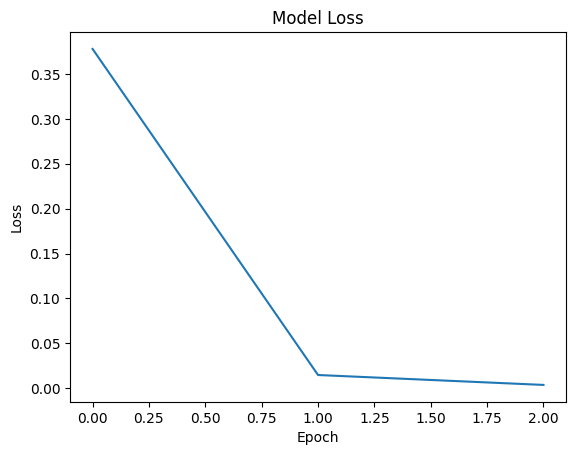

In [ ]:
# 모델 학습 과정 시각화
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# 학습된 모델 로드
model = tf.keras.models.load_model(f"{model_name}.h5")

# Calculate the reconstruction error for test_data
test_data_reconstructed = model.predict(test_data_scaled)
reconstruction_error = np.mean(np.square(test_data_scaled - test_data_reconstructed), axis=1)

231/231 [==============================] - 0s 1ms/step


In [ ]:
# Set a threshold for considering a test point as an anomaly
threshold = np.percentile(reconstruction_error, 95.34)
threshold1 = np.percentile(reconstruction_error, 95.36)

# Predict anomalies in test_data
prediction2 = (reconstruction_error > threshold).astype(int)
prediction3 = (reconstruction_error > threshold1).astype(int)

from collections import Counter

count = Counter(prediction2)
num_0 = count[0]
num_1 = count[1]

print("Number of 0s: ", num_0)
print("Number of 1s: ", num_1)

Number of 0s:  7044
Number of 1s:  345


### AutoEncoder (/w optuna)

In [ ]:
# train_data = pd.concat([train_data_10, train_data_20, train_data_30, train_data_50], ignore_index=True)
# test_data = pd.concat([test_data_10, test_data_20, test_data_30, test_data_50], ignore_index=True)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping

scaler = StandardScaler()

# Preprocess the data
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [ ]:
# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 64
hidden_dim = 32

encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(hidden_dim, activation='relu')
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(hidden_dim,)),
    tf.keras.layers.Dense(input_dim, activation='linear')
])

autoencoder = tf.keras.Sequential([encoder, decoder])

# Compile and train the autoencoder with early stopping
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose = 1)
autoencoder.fit(train_data_scaled, train_data_scaled, epochs=10000, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose = 1)
autoencoder.save('ae_ft14_standard_no_outlier.h5')

Epoch 1/10000
69/69 [==============================] - 2s 5ms/step - loss: 0.3191 - val_loss: 0.3914
Epoch 2/10000
69/69 [==============================] - 0s 3ms/step - loss: 0.0120 - val_loss: 0.0389
Epoch 3/10000
69/69 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0192
Epoch 4/10000
69/69 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0138
Epoch 5/10000
69/69 [==============================] - 0s 3ms/step - loss: 7.4411e-04 - val_loss: 0.0097
Epoch 6/10000
69/69 [==============================] - 0s 3ms/step - loss: 5.4388e-04 - val_loss: 0.0072
Epoch 7/10000
69/69 [==============================] - 0s 3ms/step - loss: 4.1455e-04 - val_loss: 0.0057
Epoch 8/10000
69/69 [==============================] - 0s 3ms/step - loss: 3.3500e-04 - val_loss: 0.0049
Epoch 9/10000
69/69 [==============================] - 0s 3ms/step - loss: 2.9065e-04 - val_loss: 0.0040
Epoch 10/10000
69/69 [==============================] - 0s 3ms/step - l

In [ ]:
# 학습된 모델 로드
model = tf.keras.models.load_model("ae_ft14_standard_no_outlier.h5")

# 이상치 탐지를 위한 reconstruction error 계산
test_data_reconstructed = model.predict(test_data_scaled)
reconstruction_error = np.mean(np.square(test_data_scaled - test_data_reconstructed), axis=1)

# 임계값(threshold) 설정
threshold = np.percentile(reconstruction_error, 95.33)

# 이상치 탐지
prediction = (reconstruction_error > threshold).astype(int)

# 이상치 출력
abnomalies = []
for idx in range(len(prediction)):
    if prediction[idx]:
        abnomalies.append(idx)
print(len(abnomalies))

231/231 [==============================] - 0s 1ms/step
346


### 기본_optuna 적용
* 하이퍼 파라미터 튜닝

In [ ]:
import optuna
from tensorflow.keras import layers, models

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the autoencoder architecture
def create_model(trial):
    activation = trial.suggest_categorical('activation', ['relu', 'elu', 'swish'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    input_dim = train_data_scaled.shape[1]
    encoding_dim = trial.suggest_int('encoding_dim', 16, 256)
    hidden_dim = trial.suggest_int('hidden_dim', 8, 128)

    encoder = tf.keras.Sequential([
        tf.keras.layers.Dense(encoding_dim, activation=activation, input_shape=(input_dim,)),
        tf.keras.layers.Dense(hidden_dim, activation=activation)
    ])

    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(encoding_dim, activation=activation, input_shape=(hidden_dim,)),
        tf.keras.layers.Dense(input_dim, activation='linear')
    ])

    autoencoder = tf.keras.Sequential([encoder, decoder])

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return autoencoder

# Define the Objective function for Optuna
def objective(trial):
    autoencoder = create_model(trial)
    
    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    autoencoder.fit(train_data_scaled, train_data_scaled, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)
    
    # Calculate the reconstruction error for test_data
    test_data_reconstructed = autoencoder.predict(test_data_scaled)
    reconstruction_error = np.mean(np.square(test_data_scaled - test_data_reconstructed), axis=1)

    # Set a threshold for considering a test point as an anomaly
    threshold = np.percentile(reconstruction_error, 95)

    # Predict anomalies in test_data
    prediction = (reconstruction_error > threshold).astype(int)

    # Calculate the MSE as the performance metric
    mse = mean_squared_error(test_data_scaled, test_data_reconstructed)
    return mse

# Use Optuna to optimize the Objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters found by Optuna
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Train the model with the best hyperparameters
best_autoencoder = create_model(best_params)
best_autoencoder.fit(train_data_scaled, train_data_scaled, 
                     epochs=500, batch_size=32, 
                     validation_split=0.1, 
                     callbacks=[early_stopping], verbose=1)

# Calculate the reconstruction error for test_data
test_data_reconstructed = best_autoencoder.predict(test_data_scaled)
reconstruction_error = np.mean(np.square(test_data_scaled - test_data_reconstructed), axis=1)

# Set a threshold for considering a test point as an anomaly
threshold = np.percentile(reconstruction_error, 95)

# Predict anomalies in test_data
prediction = (reconstruction_error > threshold).astype(int)

# # Calculate F1 score for anomaly detection
# f1 = f1_score(test_labels, prediction)
# print(f"F1 score: {f1}")

### Adversarial AutoEncoder

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 17
hidden_dim = 75

# Define the Discriminator architecture
discriminator = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim * 2,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Define the Encoder and Decoder architecture
encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(hidden_dim, activation='relu')
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(hidden_dim,)),
    tf.keras.layers.Dense(input_dim, activation='linear')
])

# Define the Adversarial Autoencoder
input_data = tf.keras.layers.Input(shape=(input_dim,))
encoded = encoder(input_data)
decoded = decoder(encoded)
ae_output = tf.keras.layers.Concatenate()([input_data, decoded])

discriminator.trainable = False
discriminator_output = discriminator(ae_output)

aae = tf.keras.Model(inputs=input_data, outputs=[decoded, discriminator_output])

# Compile and train the Adversarial Autoencoder with early stopping
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
aae.compile(loss=['mse', 'binary_crossentropy'], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
aae.fit(train_data_scaled, [train_data_scaled, np.ones((train_data_scaled.shape[0], 1))], epochs=500, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

In [ ]:
# Get the reconstructed test data from the Adversarial Autoencoder
test_data_reconstructed, _ = aae.predict(test_data_scaled)

# Calculate the reconstruction error
reconstruction_error = np.mean(np.square(test_data_scaled - test_data_reconstructed), axis=1)

# Obtain the predicted labels for the test data
# threshold = np.mean(reconstruction_error) + np.std(reconstruction_error)
threshold = np.percentile(reconstruction_error, 97)
prediction = (reconstruction_error > threshold).astype(np.int32)

print(np.mean(reconstruction_error) + np.std(reconstruction_error))


231/231 [==============================] - 0s 2ms/step
0.5941492851930237


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense
from keras.models import Model

# 데이터 전처리
scaler = StandardScaler()
train_data_scaler = scaler.fit_transform(train_data)
test_data_scaler = scaler.transform(test_data)

# AutoEncoder 모델 구현
input_dim = train_data.shape[1]
encoding_dim = 15  # encoding 차원 수
input_layer = Input(shape=(input_dim,))
encoder_layer = Dense(encoding_dim, activation='relu')(input_layer)
decoder_layer = Dense(input_dim, activation='sigmoid')(encoder_layer)
autoencoder = Model(input_layer, decoder_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# 학습 데이터에서 모델 학습
autoencoder.fit(train_data_scaler, train_data_scaler, epochs=50, batch_size=32, validation_split=0.2)

# 테스트 데이터에서 이상 탐지
test_predictions = autoencoder.predict(test_data_scaler)
mse = np.mean(np.power(test_data_scaler - test_predictions, 2), axis=1)
# threshold = np.max(mse)  # 이상 탐지 경계값 설정
test_labels = (mse > 95).astype(int)  # 이상 여부 판별

# 결과 출력
print(test_labels)

Epoch 1/50
62/62 [==============================] - 1s 4ms/step - loss: 1.2203 - val_loss: 0.6017
Epoch 2/50
62/62 [==============================] - 0s 3ms/step - loss: 0.9657 - val_loss: 0.4690
Epoch 3/50
62/62 [==============================] - 0s 3ms/step - loss: 0.7903 - val_loss: 0.4005
Epoch 4/50
62/62 [==============================] - 0s 3ms/step - loss: 0.7227 - val_loss: 0.3723
Epoch 5/50
62/62 [==============================] - 0s 3ms/step - loss: 0.6944 - val_loss: 0.3572
Epoch 6/50
62/62 [==============================] - 0s 3ms/step - loss: 0.6798 - val_loss: 0.3476
Epoch 7/50
62/62 [==============================] - 0s 3ms/step - loss: 0.6706 - val_loss: 0.3397
Epoch 8/50
62/62 [==============================] - 0s 3ms/step - loss: 0.6638 - val_loss: 0.3332
Epoch 9/50
62/62 [==============================] - 0s 3ms/step - loss: 0.6586 - val_loss: 0.3273
Epoch 10/50
62/62 [==============================] - 0s 3ms/step - loss: 0.6546 - val_loss: 0.3223
Epoch 11/50
62/62 [

## Feature Importance 확인

Compressor_Efficiency2: 1.47
air_inflow_per_motor_current: 1.46
type: 1.45
hp: 1.37
motor_vibe: 1.35
motor_temp: 1.35
Compressor_Efficiency1: 1.34
air_end_temp: 1.33
Discharge_Volume: 1.33
motor_current: 1.29
air_inflow: 1.28
out_pressure: 1.26
air_density: 1.26
motor_rpm: 1.24
Motor_Efficiency: 1.10


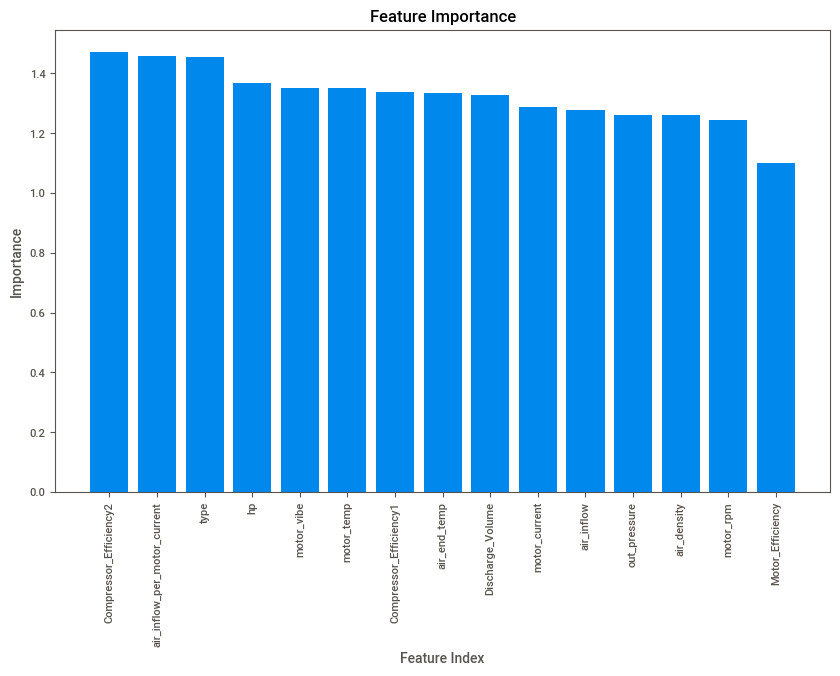

In [ ]:
import matplotlib.pyplot as plt

columns = train_data.columns

# Extract encoder layer and weights
encoder_layer = model.layers[0]
weights = encoder_layer.get_weights()[0]

# Calculate feature importance as the L2 norm of weights
feature_importance = np.linalg.norm(weights, axis=1)

# Sort feature importance in descending order
sorted_importance_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_importance_indices]

# Print sorted feature importance
for i in range(len(sorted_importance)):
    print('{}: {:.2f}'.format(columns[sorted_importance_indices[i]], sorted_importance[i]))

# Create bar chart of sorted feature importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_importance)), sorted_importance)
ax.set_title('Feature Importance')
ax.set_xlabel('Feature Index')
ax.set_ylabel('Importance')
ax.set_xticks(range(len(sorted_importance)))
ax.set_xticklabels(columns[sorted_importance_indices])
plt.xticks(rotation=90)
plt.show()

# 데이터 저장

In [ ]:
cnt = 0
for a, b in zip(prediction, prediction2):
    if a != b:
        cnt +=1
print(cnt)

6


In [ ]:
file_name = 'ae_ft14_standard_no_outlier_dupl_th9535'

In [ ]:
# 코랩에 저장
idx = test_data.loc[:, 'type']
y_pred = {'type': idx, 'label': prediction2}
test_prediction = pd.DataFrame(y_pred)
test_prediction.to_csv(f"{file_name}.csv")

In [ ]:
# 구글드라이브에 저장(연동 필요)
idx = test_data.loc[:, 'type']
y_pred = {'type': idx, 'label': prediction}
test_prediction = pd.DataFrame(y_pred)
test_prediction.to_csv(f"/content/drive/MyDrive/AIFactory/dataset/{file_name}.csv")